Gun Laws vs Death Rates
=============

It turns out that Wikipedia has a page on [firearm death rates by state](https://en.wikipedia.org/wiki/Firearm_death_rates_in_the_United_States_by_state). That page has a nice little table for death rates per 100,000 population in 2013. Furthermore, there is also a page on [gun laws per state](https://en.wikipedia.org/wiki/Gun_laws_in_the_United_States_by_state).

Let's do something stupidly simple: Let's count up the gun laws in each state, and compare it to the firearm death rates. 

This is obviously a very flawed metric, but it serves as a good initial sanity check. I expect there to be a pretty strong negative relation - the more gun control laws, the less gun-related deaths. If that is found, then sanity check passed, and barring more in-depth research showing otherwise, I can accept that adding gun control laws could plausibly decrease the gun death rate.

Scraping the wikipedia articles turns out to be surprisingly easy using pandas:


In [107]:
import pandas as pd

# Read the tables from the wikipedia page, and return the second one (index 1), which corresponds to the
# gun death rate per state.
gun_death_rate = pd.read_html("https://en.wikipedia.org/wiki/Firearm_death_rates_in_the_United_States_by_state",
             header=0,
             attrs={"class": ["sortable","wikitable", "plainrowheaders"]})[1]

# Read the tables from the gun laws wikipedia page, and return the 51 tables corresponding to the gun laws
# in each state, plus the district of columbia
per_state_gun_laws = pd.read_html("https://en.wikipedia.org/wiki/Gun_laws_in_the_United_States_by_state",header=0)[1:-7]


Now we combine the two datasets by just counting the laws per state:

In [113]:

# Let's extract the number of restrictions (ie, count the number of laws) for each state
number_of_restrictions_per_state = []
for state_laws in per_state_gun_laws:
    # Everywhere there is a "Yes", we say that there is an additional restriction,
    # except for the "open carry" row, which is reversed, disallowing open carry is
    # a restriction
    open_carry_row = (state_laws[state_laws["Subject/Law"].str.contains("Open carry|Open Carry")].index[0])
    
    handgun_restrictions = (state_laws["Handguns"].str.contains("Yes") 
                            + 0.5*state_laws["Handguns"].str.contains("Partial"))
    handgun_restrictions[open_carry_row] = 1 - handgun_restrictions[open_carry_row]
    
    # Annoyingly, wikipedia uses two different table headings
    try:
        longgun_restrictions = (state_laws["Long Guns"].str.contains("Yes")
                                + 0.5*state_laws["Long Guns"].str.contains("Partial"))
    except:
        longgun_restrictions = (state_laws["Long guns"].str.contains("Yes")
                                + 0.5*state_laws["Long guns"].str.contains("Partial"))
        
    longgun_restrictions[open_carry_row] = 1 - longgun_restrictions[open_carry_row]
    
    number_of_restrictions_per_state.append(handgun_restrictions.sum() + longgun_restrictions.sum())

# Thankfully the states are alphabetical in both wikipedia pages, so they match up without any more work.
# We just need to remove the district of columbia (8th element, 0-indexed)
del number_of_restrictions_per_state[8]
full_dataset = gun_death_rate.assign(Laws=number_of_restrictions_per_state)

# Now a bit of cleanup:
# Winsconsin has a weird table, which we need to fix manually
full_dataset.loc[full_dataset["State"]=="Wisconsin","Laws"] += 3

full_dataset

State   Rate  Laws
0          Alabama  17.79   3.0
1           Alaska  19.59   4.0
2          Arizona  14.20   3.0
3         Arkansas  16.93   6.0
4       California   7.89  21.0
5         Colorado  11.75  13.0
6      Connecticut   4.48  16.0
7         Delaware  10.80   8.0
8          Florida  12.49   5.0
9          Georgia  12.63   3.0
10          Hawaii   2.71  13.0
11           Idaho  14.08   2.0
12        Illinois   8.67  16.0
13         Indiana  13.04   9.0
14            Iowa   8.19   8.0
15          Kansas  11.44   2.0
16        Kentucky  14.15   5.0
17       Louisiana  19.15   3.0
18           Maine  11.89   4.0
19        Maryland   9.75  10.0
20   Massachusetts   3.18  14.0
21        Michigan  12.03   5.0
22       Minnesota   7.88   7.0
23     Mississippi  17.55   4.0
24        Missouri  14.56   4.0
25         Montana  16.94   5.0
26        Nebraska   8.99   5.0
27          Nevada  14.16   5.0
28   New Hampshire   7.03   2.0
29      New Jersey   5.69  12.0
30      New Mexico  15.63   7.5
31        New York   4.39  17.0
32  North Carolina  12.42   7.0
33    North Dakota  11.89   4.0
34            Ohio  11.14   6.0
35        Oklahoma  16.41   6.0
36          Oregon  11.76   8.0
37    Pennsylvania  11.36   9.0
38    Rhode Island   5.33  12.0
39  South Carolina  15.60   4.0
40    South Dakota   9.47   3.0
41       Tennessee  15.86   7.0
42           Texas  10.50   8.0
43            Utah  11.69  12.0
44         Vermont  10.37   2.0
45        Virginia  10.46   5.0
46      Washington   9.07   8.5
47   West Virginia  15.10   4.0
48       Wisconsin   9.93   7.0
49         Wyoming  17.51   2.0

So, let's plot it!

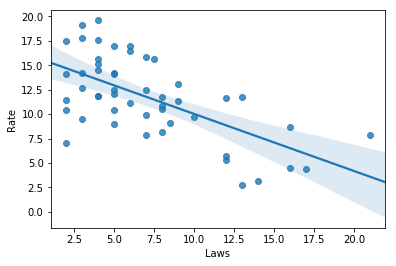

In [114]:
%matplotlib inline
import seaborn as sb

sb.regplot(x="Laws",y="Rate",data=full_dataset)

Given the large negative correlation, unless research is sent to me with a more in-depth analysis of the issue, I can accept that it is very plausible[^1] that adding gun control laws would decrease the firearm death rate.

[^1]: Correlation does not imply causation.